# Debugging Applications

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import END, START
from langgraph.graph.state import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
from langchain_groq import ChatGroq

import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# loading the lapi keys
groq_api_key = os.getenv("GROQ_API")
langsmith_api_key = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "test_project"

# intialising llm
llm = ChatGroq(model = "llama3-70b-8192", api_key = groq_api_key)


In [3]:
## State graph with tool call

# Defining State
class State(TypedDict):
    messages : Annotated[list[BaseMessage], add_messages] #keeps the list of all the messages added

# Defining the tool
@tool
def add(a:float, b:float)->float:
    """
    Add two numbers

    """
    return a+b

tool = add
tool_node = ToolNode([tool])

# binding the llm
llm_with_tool = llm.bind_tools([add])

# Defining node
def call_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}


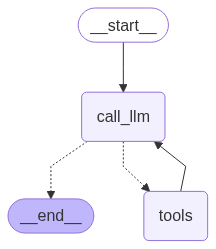

In [7]:
# Graph building
graph_builder = StateGraph(State)
graph_builder.add_node("call_llm", call_llm)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START,"call_llm")
graph_builder.add_conditional_edges("call_llm", tools_condition)

graph_builder.add_edge("tools","call_llm")

graph= graph_builder.compile()
graph


In [5]:
# invoking the chatbot
response_1 = graph.invoke({"messages":"What is the recent health news in India"})
response_1

{'messages': [HumanMessage(content='What is the recent health news in India', additional_kwargs={}, response_metadata={}, id='c6086f6c-442b-47a7-9831-5a582257d38e'),
  AIMessage(content="As of my knowledge cutoff, some recent health news in India includes:\n\n* The COVID-19 pandemic continues to be a major public health concern in India, with the government taking various measures to control the spread of the virus, including vaccination drives and restrictions on gatherings.\n* India has seen a significant increase in cases of mucormycosis, a rare fungal infection, particularly among COVID-19 patients who have been treated with steroids.\n* The Indian government has launched several initiatives to improve healthcare infrastructure and access to healthcare services, including the Ayushman Bharat program, which aims to provide health insurance coverage to millions of people.\n* There have been reports of outbreaks of diseases such as dengue fever, chikungunya, and swine flu in various p

In [6]:
response_2 = graph.invoke({"messages":"What is 2+5"})
response_2

{'messages': [HumanMessage(content='What is 2+5', additional_kwargs={}, response_metadata={}, id='8e7553c6-23b6-4cf5-ae58-8c1c3b081eb7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'y097rfe8c', 'function': {'arguments': '{"a":2,"b":5}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 897, 'total_tokens': 933, 'completion_time': 0.11169916, 'prompt_time': 0.028631859, 'queue_time': 0.209277377, 'total_time': 0.140331019}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--16ccaca2-db00-428c-8ae0-5038a2a97218-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 5}, 'id': 'y097rfe8c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 897, 'output_tokens': 36, 'total_tokens': 933}),
  ToolMessage(content='7.0', name='add', id='51f43d18-c55f-4bb0-8113-604d75fb6594', tool_call_id='y097rfe8c')]}